In [1]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.layers import Input


In [2]:
def create_large_eye_classifier(input_shape=(64, 64, 1)):
    """
    Creates a large CNN model with approximately 30M parameters
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(1024, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(1024, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Flatten layer
        Flatten(),

        # Dense layers
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile with appropriate optimizer and loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for stability
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()]
    )

    return model

In [3]:
# Setup data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3]
)

In [4]:
# Create data generators with smaller batch size for large model
batch_size = 8  # Reduced for larger model
img_height = 64
img_width = 64

In [5]:
train_generator = train_datagen.flow_from_directory(
    'data2',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

Found 67919 images belonging to 2 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    'data2',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

Found 16979 images belonging to 2 classes.


In [7]:
# Create and train the model
model = create_large_eye_classifier()

In [8]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                        

In [9]:
# Training
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
)

Epoch 1/200
8490/8490 [==============================] - 443s 52ms/step - loss: 0.6386 - accuracy: 0.7014 - precision: 0.7071 - recall: 0.6997 - auc: 0.7799 - val_loss: 0.1966 - val_accuracy: 0.9254 - val_precision: 0.9342 - val_recall: 0.9171 - val_auc: 0.9756
Epoch 2/200
8490/8490 [==============================] - 447s 53ms/step - loss: 0.2136 - accuracy: 0.9299 - precision: 0.9320 - recall: 0.9291 - auc: 0.9714 - val_loss: 0.1827 - val_accuracy: 0.9416 - val_precision: 0.9505 - val_recall: 0.9331 - val_auc: 0.9826
Epoch 3/200
8490/8490 [==============================] - 449s 53ms/step - loss: 0.1448 - accuracy: 0.9598 - precision: 0.9601 - recall: 0.9606 - auc: 0.9855 - val_loss: 0.1692 - val_accuracy: 0.9393 - val_precision: 0.9762 - val_recall: 0.9020 - val_auc: 0.9816
Epoch 4/200
8490/8490 [==============================] - 448s 53ms/step - loss: 0.1264 - accuracy: 0.9642 - precision: 0.9638 - recall: 0.9655 - auc: 0.9882 - val_loss: 0.0960 - val_accuracy: 0.9647 - val_precision

In [10]:
# Save the quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\VIRAT\AppData\Local\Temp\tmpzbr3tcq3\assets


INFO:tensorflow:Assets written to: C:\Users\VIRAT\AppData\Local\Temp\tmpzbr3tcq3\assets


In [11]:
# Save the quantized model to disk
with open('quantized_eye_classifier.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

In [12]:
# Function to evaluate model size
def get_model_size(file_path):
    import os
    size_in_bytes = os.path.getsize(file_path)
    size_in_mb = size_in_bytes / (1024 * 1024)
    return f"Model Size: {size_in_mb:.2f} MB"

print(get_model_size('quantized_eye_classifier.tflite'))

Model Size: 110.01 MB


In [13]:
# Function to plot training metrics
def plot_training_metrics(history):
    import matplotlib.pyplot as plt
    
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        if metric in history.history:
            plt.subplot(2, 3, i)
            plt.plot(history.history[metric], label=f'Training {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(f'Model {metric}')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.legend()
    
    plt.tight_layout()
    plt.show()

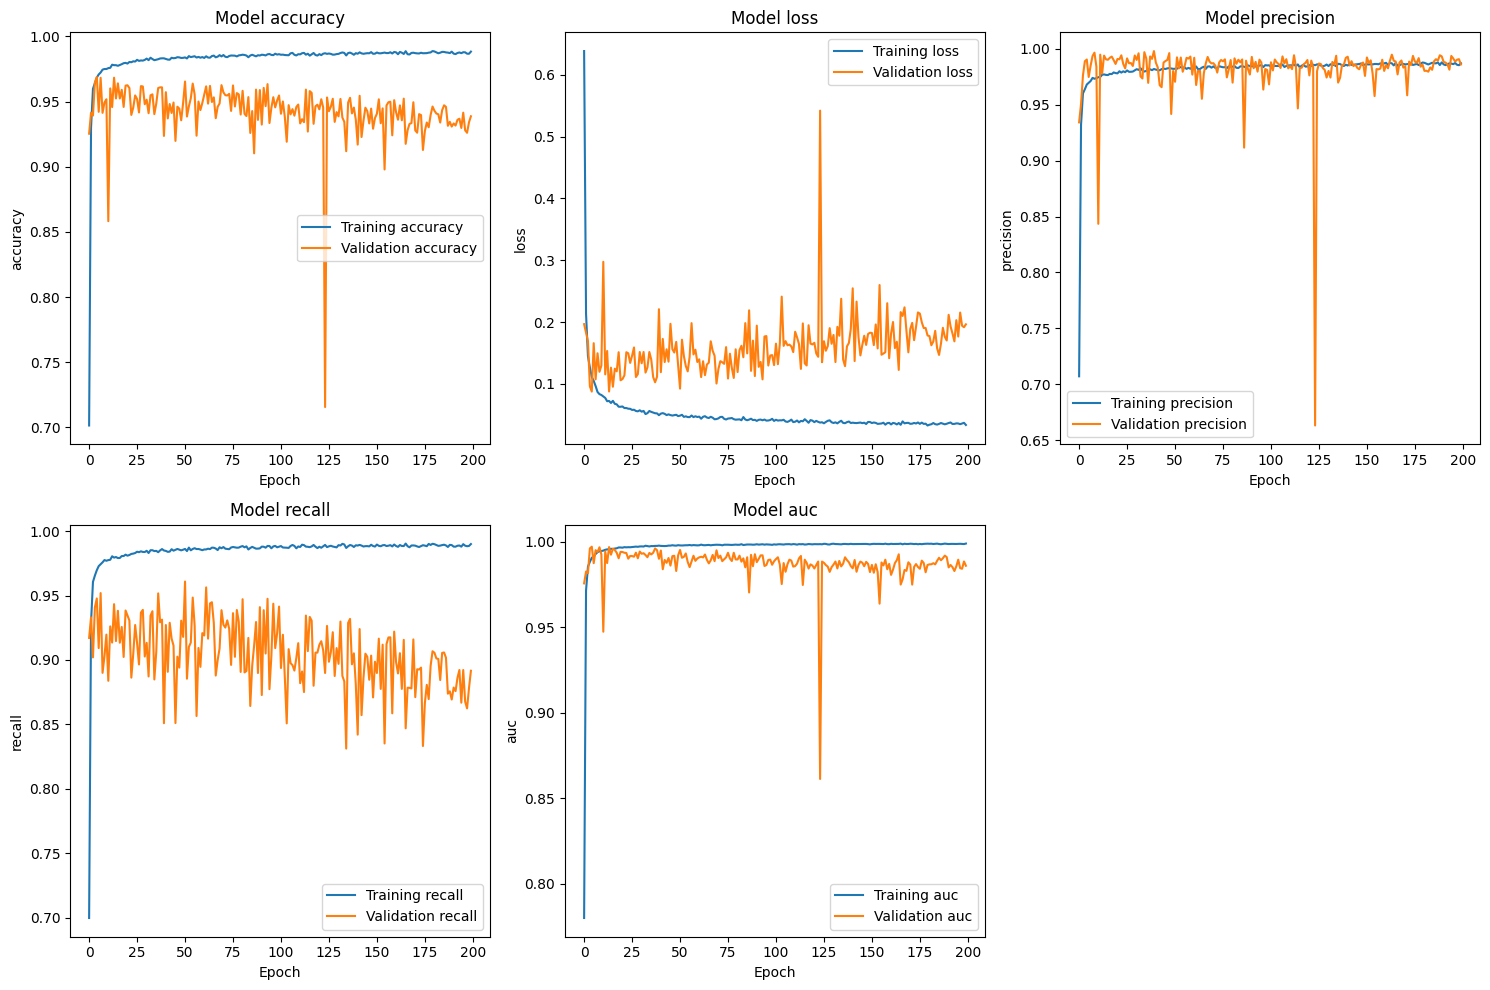

In [14]:
# Plot the metrics
plot_training_metrics(history)